In [0]:
%matplotlib inline

In [32]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import nltk
nltk.download('punkt')


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        #print("input:", sentence)
        tokenized_text = nltk.word_tokenize(sentence)

        #print("tokenized:", tokenized_text)
        for word in tokenized_text:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
import codecs
import csv
import random

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    #lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
#     lines = open('arabic.txt', encoding='utf-8')
#         read().strip().split('\n')
#     print (lines)
    

    #FILENAME = "arabic_words.csv"
    FILENAME = "arabic_sentences_4_short_medium.csv"
    ENCODING = 'utf-8'
    pairs = []
    with codecs.open(FILENAME, "r", ENCODING) as fp:
      reader = csv.reader(fp)
      for rows in reader:
        #print("Row:", rows[0])
        #ascii = normalizeString(row[0])
        pairs.append(rows)
        
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    return input_lang, output_lang, pairs
#     # Split every line into pairs and normalize
#     pairs = [[normalizeString(s) for s in l.split(',')] for l in lines]

#     # Reverse pairs, make Lang instances
#     if reverse:
#         pairs = [list(reversed(p)) for p in pairs]
#         input_lang = Lang(lang2)
#         output_lang = Lang(lang1)
#     else:
#         input_lang = Lang(lang1)
#         output_lang = Lang(lang2)

        

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [35]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
  
    print("Read %s sentence pairs" % len(pairs))
    #pairs = filterPairs(pairs)
    #print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        #print("printing pairs:", pair[0], pair[1])
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('NoDiac', 'Diac', False)
print(random.choice(pairs))


Reading lines...
Read 1000 sentence pairs
Counting words...
Counted words:
NoDiac 2087
Diac 2525
['الكور وهجا العديل بن', 'الكَوْرِ وهَجا العُدَيلُ بن']


In [36]:
#print(random.choice([input_lang.word2index.keys()]))
#print(random.choice([output_lang.word2index.keys()]))
print([input_lang.word2index])
print([output_lang.word2index])


[{'no_diacritics': 2, 'الصحاح': 3, 'في': 4, 'اللغةالصحاح': 5, 'للأجهزة': 6, 'المحمولة': 7, 'لا': 8, 'توجد': 9, 'كلمات': 10, 'أو': 11, 'تعابير': 12, 'مطابقة': 13, 'ذات': 14, 'صلة': 15, 'الباحث': 16, 'المصدر': 17, 'عرب': 18, 'العرب': 19, 'لسان': 20, 'والعرب': 21, 'جيل': 22, 'من': 23, 'الناس': 24, 'معروف': 25, 'خلاف': 26, 'العجم': 27, 'وهما': 28, 'واحد': 29, 'مثل': 30, 'والعجم': 31, 'مؤنث': 32, 'الجوهري': 33, 'العريب': 34, 'تصغير': 35, 'قال': 36, 'أبو': 37, 'الهندي': 38, 'واسمه': 39, 'عبدالمؤمن': 40, 'ابن': 41, 'عبدالقدوس': 42, 'فأما': 43, 'البهط': 44, 'وحيتانكم': 45, 'فما': 46, 'زلت': 47, 'فيها': 48, 'كثير': 49, 'السقم': 50, 'وقد': 51, 'نلت': 52, 'منها': 53, 'كما': 54, 'نلتم': 55, 'فلم': 56, 'أر': 57, 'كضب': 58, 'هرم': 59, 'وما': 60, 'البيوض': 61, 'كبيض': 62, 'الدجاج': 63, 'وبيض': 64, 'الجراد': 65, 'شفاء': 66, 'القرم': 67, 'ومكن': 68, 'الضباب': 69, 'طعام': 70, 'العريـ': 71, 'ـب': 72, 'تشتهيه': 73, 'نفوس': 74, 'صغرهم': 75, 'تعظيما': 76, 'أنا': 77, 'جذيلها': 78, 'المحكك': 79, 'وعذيقها': 80

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
MAX_LENGTH = 10

In [17]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
       

NameError: ignored

In [0]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    #print("Pair is:",pair[0],pair[1])
    #print("Tensors:",input_tensor, target_tensor)
    return (input_tensor, target_tensor)

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    #print("input_length",input_length,"target_length:",target_length)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    #print(encoder_outputs.shape)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    #use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    use_teacher_forcing = False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        #print("Training pair", training_pair)
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    #print ("got here")
    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
           # decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
           # decoder_attentions[di] = decoder_attention.data
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                #decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        #return decoded_words, decoder_attentions[:di + 1]
        return decoded_words

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    correct = 0
    incorrect = 1
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        #output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        if (pair[1] == output_sentence):
          correct += 1
        else:
          print("Example incorrect:")
          incorrect += 0
    print("accuracy:",correct/(correct+incorrect),correct,incorrect) 

In [26]:
print("input:", input_lang.n_words)

input: 288


0m 22s (- 14m 28s) (500 2%) 4.8215
0m 45s (- 14m 16s) (1000 5%) 5.6030
1m 8s (- 14m 5s) (1500 7%) 5.8848
1m 32s (- 13m 51s) (2000 10%) 5.7894
1m 57s (- 13m 42s) (2500 12%) 5.6811
2m 22s (- 13m 28s) (3000 15%) 5.4050
2m 48s (- 13m 13s) (3500 17%) 5.2739
3m 14s (- 12m 57s) (4000 20%) 5.0876
3m 40s (- 12m 40s) (4500 22%) 4.8030
4m 9s (- 12m 27s) (5000 25%) 4.6281
4m 36s (- 12m 9s) (5500 27%) 4.3582
5m 2s (- 11m 46s) (6000 30%) 4.0622
5m 29s (- 11m 24s) (6500 32%) 3.8893
5m 56s (- 11m 1s) (7000 35%) 3.6500
6m 23s (- 10m 38s) (7500 37%) 3.4052
6m 49s (- 10m 14s) (8000 40%) 3.1451
7m 18s (- 9m 52s) (8500 42%) 2.9618
7m 45s (- 9m 28s) (9000 45%) 2.5055
8m 12s (- 9m 4s) (9500 47%) 2.5555
8m 40s (- 8m 40s) (10000 50%) 2.1683
9m 7s (- 8m 15s) (10500 52%) 2.0355
9m 34s (- 7m 50s) (11000 55%) 1.7586
10m 1s (- 7m 24s) (11500 57%) 1.6662
10m 28s (- 6m 59s) (12000 60%) 1.4467
10m 56s (- 6m 33s) (12500 62%) 1.2925
11m 24s (- 6m 8s) (13000 65%) 1.1095
11m 51s (- 5m 42s) (13500 67%) 0.9869
12m 19s (- 5m

<Figure size 432x288 with 0 Axes>

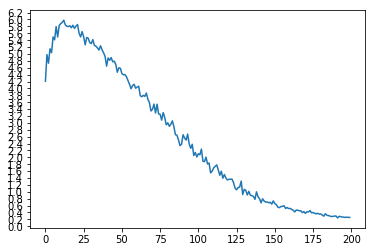

In [44]:
hidden_size = 256

encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
#attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
#print("Embeddings:", encoder1.embedding)

#trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
#trainIters(encoder1, decoder1, 10000, print_every=5000)
trainIters(encoder1, decoder1, 20000, print_every=500)

In [51]:
evaluateRandomly(encoder1, decoder1)

> شذ بعضهم عنها رد
= شَذَّ بعضهم عنها رُدَّ
< شَذَّ بعضهم عنها رُدَّ

> يعرب عربا وعروبا عن
= يعرب عرباً وعروباً عن
< يعرب عرباً وعروباً عن

> فلان نحية القوارع إذا
= فلان نَحِيَّةُ القَوارِعِ إذا
< فلان نَحِيَّةُ القَوارِعِ إذا

> قالوالعرب الأثر بفتح الراء
= قالوالعَرَب الأَثَر بفتح الراء
< قالوالعَرَب الأَثَر بفتح الراء

> مؤتشبو الزناد وقيل رخوو
= مُؤْتَشِبُو الزناد وقيل رِخْوُو
< مُؤْتَشِبُو الزناد وقيل رِخْوُو

> الذي جاء إن العربية
= الذي جاء إنَّ العربيَّة
< الذي جاء إنَّ العربيَّة

> وفصح العجمي فصاحة إذا
= وفَصُح العجميُّ فَصاحةً إذا
< وفَصُح العجميُّ فَصاحةً إذا

> وبذلك تعرف حاله أصلب
= وبذلك تُعرفُ حالهُ أصلبٌ
< وبذلك تُعرفُ حالهُ أصلبٌ

> الشيء جدوانتحى الفرس في
= الشيء جَدَّوانتحى الفرَس في
< الشيء جَدَّوانتحى الفرَس في

> العرب وباحة دار أبي
= العَرَبِ وباحةُ دارِ أبي
< العَرَبِ وباحةُ دارِ أبي

accuracy: 0.9090909090909091 10 1


Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




In [0]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




In [0]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")